In [1]:
import pandas as pd

df = pd.read_csv("./rosa-parks-in-her-own-words_2022-10-12.csv")
df = df.dropna(subset=["Transcription"])
df = df.reset_index(drop=True)

df.head()

Campaign        Project  \
0  Rosa Parks: In Her Own Words  Family Papers   
1  Rosa Parks: In Her Own Words  Family Papers   
2  Rosa Parks: In Her Own Words  Family Papers   
3  Rosa Parks: In Her Own Words  Family Papers   
4  Rosa Parks: In Her Own Words  Family Papers   

                                                Item        ItemId  \
0  Rosa Parks Papers: Family Papers, 1900-2005; L...  mss859430010   
1  Rosa Parks Papers: Family Papers, 1900-2005; L...  mss859430010   
2  Rosa Parks Papers: Family Papers, 1900-2005; L...  mss859430010   
3  Rosa Parks Papers: Family Papers, 1900-2005; L...  mss859430010   
4  Rosa Parks Papers: Family Papers, 1900-2005; L...  mss859430011   

            Asset  AssetId AssetStatus  \
0  mss859430010-1   225615   completed   
1  mss859430010-2   225616   completed   
2  mss859430010-3   225617   completed   
3  mss859430010-4   225618   completed   
4  mss859430011-1   225619   completed   

                                         DownloadUrl  \
0  http://tile.loc.gov/image-services/iiif/servic...   
1  http://tile.loc.gov/image-services/iiif/servic...   
2  http://tile.loc.gov/image-services/iiif/servic...   
3  http://tile.loc.gov/image-services/iiif/servic...   
4  http://tile.loc.gov/image-services/iiif/servic...   

                                       Transcription Tags  
0  ROSA PARKS     FAMILY PAPERS       Letters to ...  NaN  
1  May 15, 1950.\r\nPatterson Calif\r\n\r\nMy Dea...  NaN  
2  Jas. McCauley                                 ...  NaN  
3  for these many years. in Grose\r\ndesertion of...  NaN  
4  ROSA PARKS      FAMILY PAPERS            Lette...  NaN

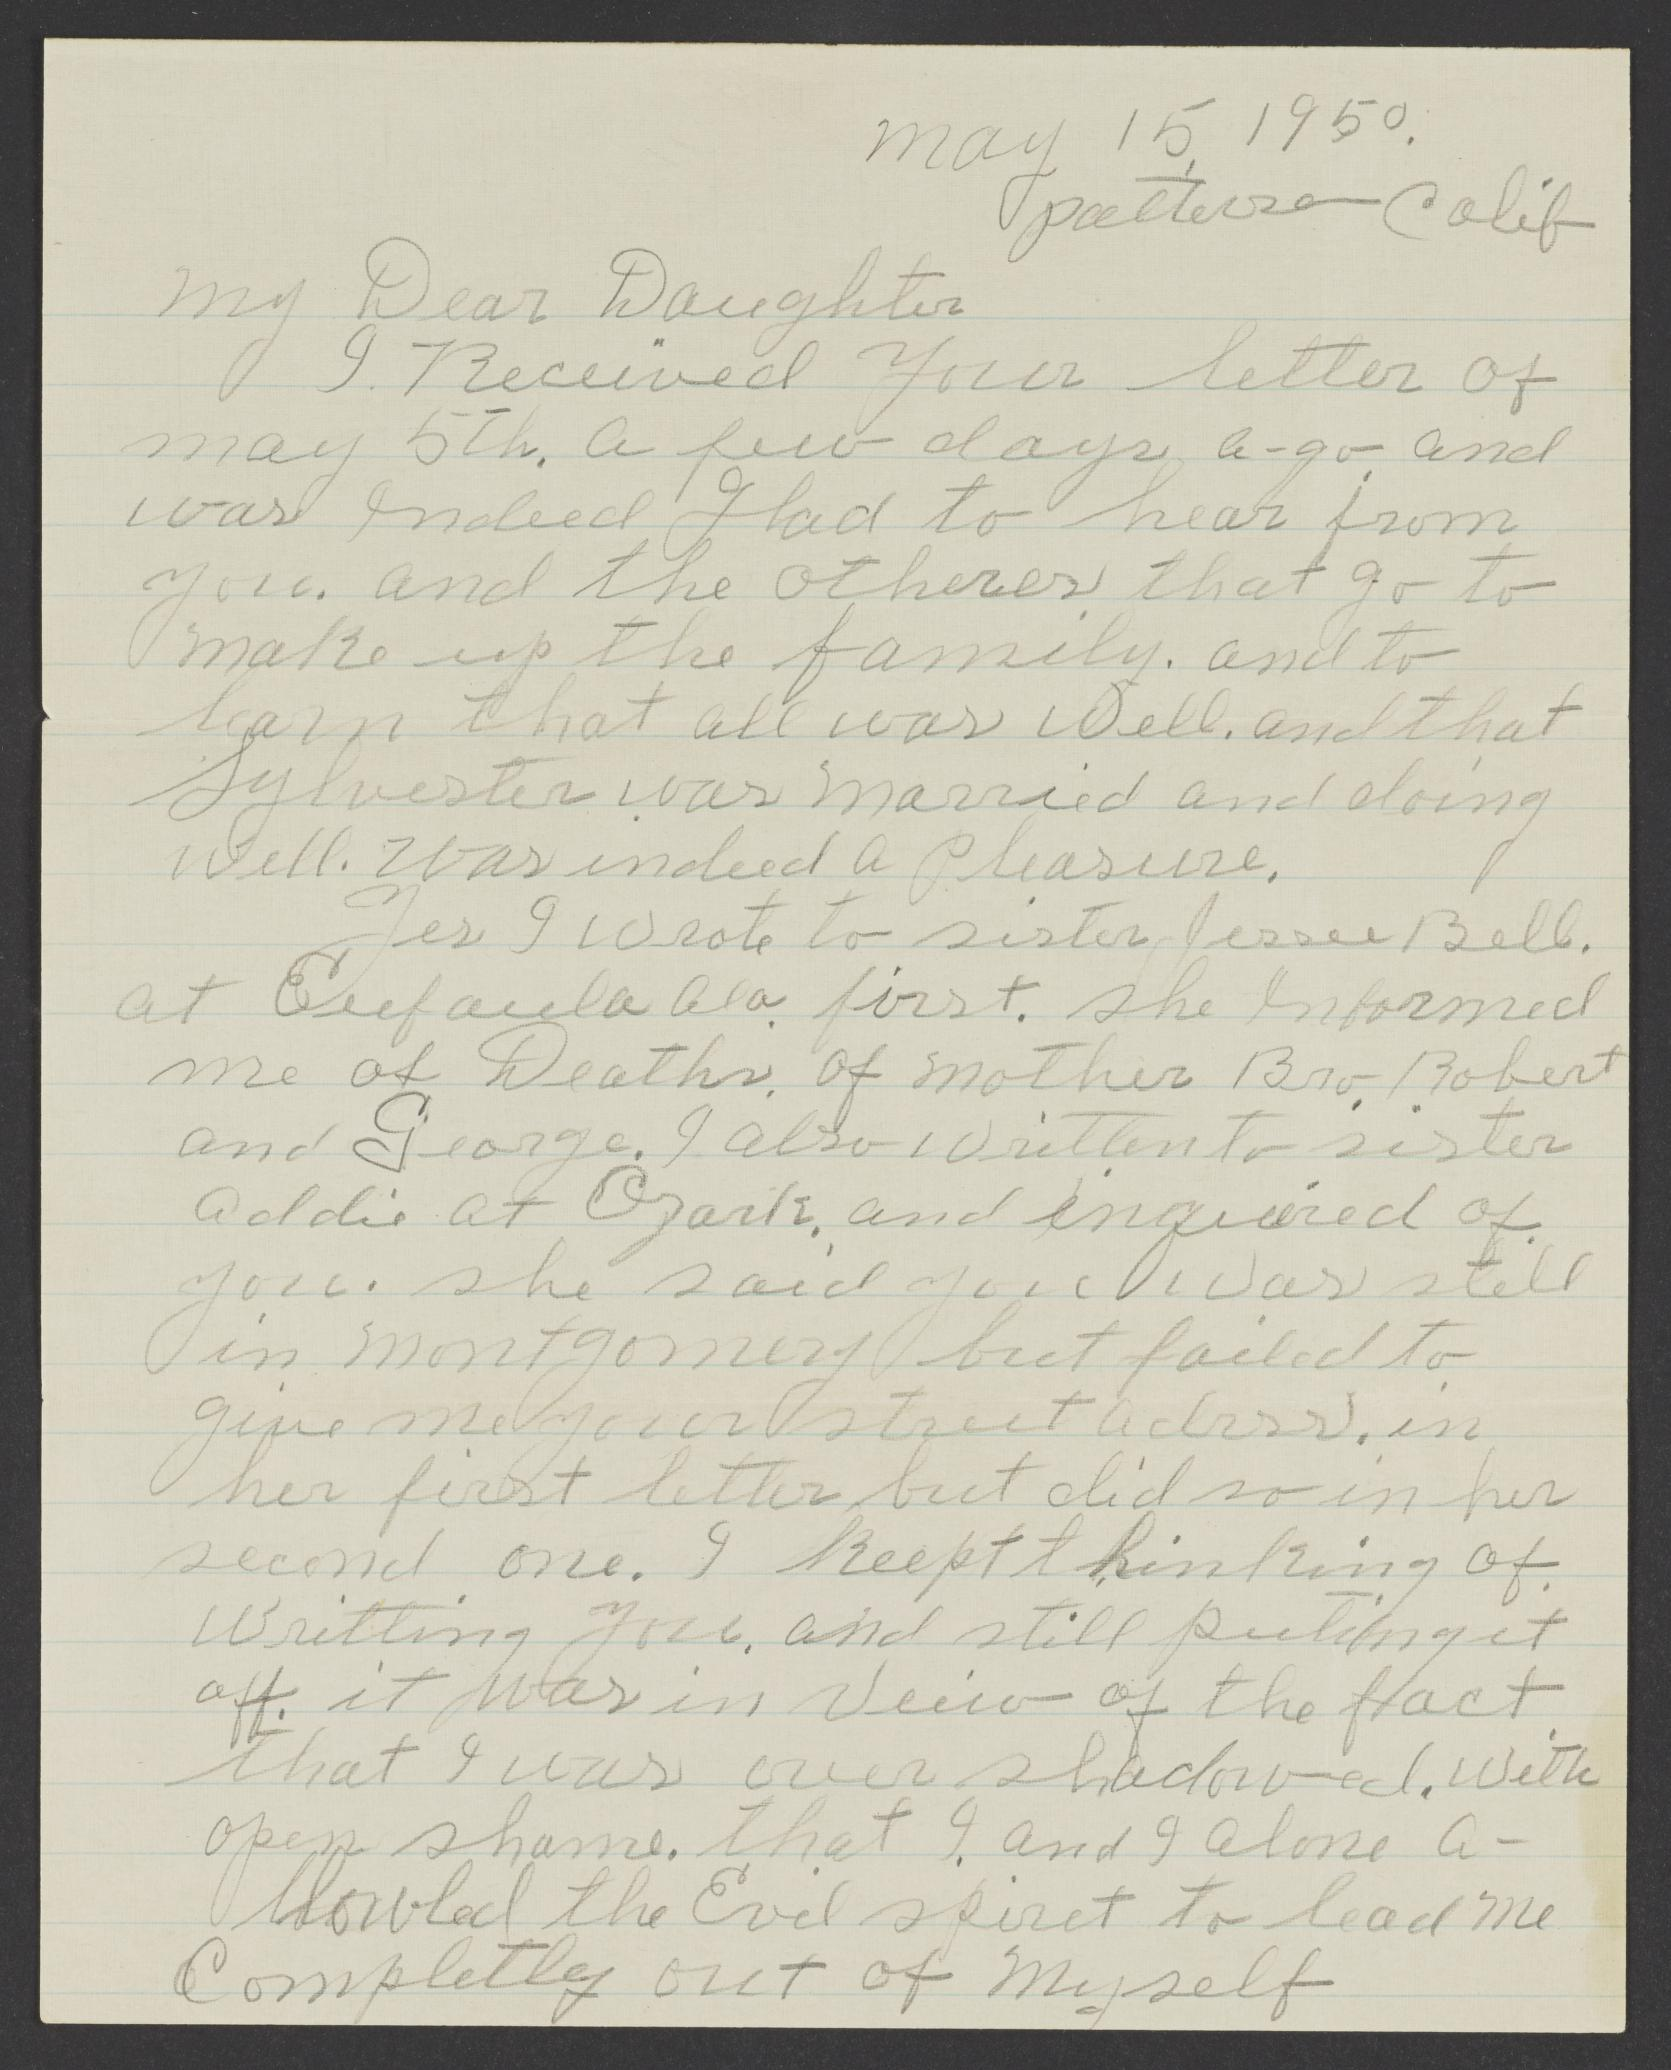

In [2]:
from PIL import Image
import requests

img = Image.open(requests.get(df.iloc[1].DownloadUrl, stream=True).raw)
img

In [3]:
for i, row in df.iterrows():
    if pd.isna(row.Project):
        project = "No project name"
    else:
        project = row.Project
    
    if pd.isna(row.Item):
        item = "No item name"
    else:
        item = row.Item
    
    if pd.isna(row.Asset):
        asset = "No asset name"
    else:
        asset = row.Asset
    
    if pd.isna(row.Transcription):
        transcription = "No transcription"
    else:
        transcription = row.Transcription
    
    if pd.isna(row.DownloadUrl):
        download_url = "No download URL"
    else:
        download_url = row.DownloadUrl
    
    if pd.isna(row.Tags):
        tags = "No tags"
    else:
        tags = row.Tags
    
    print(f"Project: {project}")
    print(f"Item: {item}")
    print(f"Asset: {asset}")
    print(f"Download URL: {download_url}")
    print(f"Tags: {tags}")
    print('---')

Project: Family Papers
Item: Rosa Parks Papers: Family Papers, 1900-2005; Letters to and from Rosa Parks; McCauley, James (father), 1950
Asset: mss859430010-1
Download URL: http://tile.loc.gov/image-services/iiif/service:mss:mss85943:0002:01:0001/full/pct:25/0/default.jpg
Tags: No tags
---
Project: Family Papers
Item: Rosa Parks Papers: Family Papers, 1900-2005; Letters to and from Rosa Parks; McCauley, James (father), 1950
Asset: mss859430010-2
Download URL: http://tile.loc.gov/image-services/iiif/service:mss:mss85943:0002:01:0002/full/pct:50/0/default.jpg
Tags: No tags
---
Project: Family Papers
Item: Rosa Parks Papers: Family Papers, 1900-2005; Letters to and from Rosa Parks; McCauley, James (father), 1950
Asset: mss859430010-3
Download URL: http://tile.loc.gov/image-services/iiif/service:mss:mss85943:0002:01:0003/full/pct:50/0/default.jpg
Tags: No tags
---
Project: Family Papers
Item: Rosa Parks Papers: Family Papers, 1900-2005; Letters to and from Rosa Parks; McCauley, James (fath

In [4]:
from whoosh.fields import Schema, TEXT, KEYWORD, ID
from whoosh.analysis import StemmingAnalyzer

schema = Schema(
    project=KEYWORD(stored=True),
    item=KEYWORD(stored=True),
    asset=ID(stored=True),
    transcription=TEXT(stored=True, analyzer=StemmingAnalyzer()),
    dl_url=TEXT(stored=True),
    tag=KEYWORD(stored=True),
)

In [5]:
from whoosh import index
import os

if not os.path.exists("parks_index"):
    os.mkdir("parks_index")

ix = index.create_in("parks_index", schema)

In [6]:
writer = ix.writer()

for i, row in df.iterrows():
    if pd.isna(row.Project):
        project = "No project name"
    else:
        project = row.Project
    
    if pd.isna(row.Item):
        item = "No item name"
    else:
        item = row.Item
    
    if pd.isna(row.Asset):
        asset = "No asset name"
    else:
        asset = row.Asset
    
    if pd.isna(row.Transcription):
        transcription = "No transcription"
    else:
        transcription = row.Transcription
    
    if pd.isna(row.DownloadUrl):
        download_url = "No download URL"
    else:
        download_url = row.DownloadUrl
    
    if pd.isna(row.Tags):
        tags = "No tags"
    else:
        tags = row.Tags

    writer.add_document(
        project=project,
        item=item,
        asset=asset,
        transcription=transcription,
        dl_url=download_url,
        tag=tags,
    )
    
writer.commit()

In [7]:
from whoosh.index import open_dir

ix = open_dir("parks_index")

In [8]:
ix.is_empty()

False

In [14]:
from whoosh import query
from whoosh.qparser import QueryParser

query_str = "bus"
parser = QueryParser("transcription", ix.schema)
q = parser.parse(query_str)

with ix.searcher() as searcher:
    res = searcher.search(q, limit=None)
    for hit in res:
        print(hit['project'])
        print(hit['item'])
        print(hit['asset'])
        print(hit.highlights("transcription"))
        print(hit['dl_url'])
        print('---')

Writings, Notes, and Statements
Rosa Parks Papers: Writings, Notes, and Statements, 1956-1998; Drafts of early writings; Accounts of her arrest and the subsequent boycott, as well as general reflections on race relations in the South, 1956-circa 1958, undated; Folder 2
mss859430226-10
Montg'y City Lines <b class="match term0">bus</b> drivers
toward Negro...the front of the <b class="match term0">bus</b>. Negroes the 
rear. There...they never boarded a <b class="match term0">bus</b>.
At least space for 10
http://tile.loc.gov/image-services/iiif/service:mss:mss85943:0018:10:0010/full/pct:50/0/default.jpg
---
Writings, Notes, and Statements
Rosa Parks Papers: Writings, Notes, and Statements, 1956-1998; Interviews; Radcliffe College, Cambridge, Mass., Black Women Oral History Project, 1978
mss859430230-23
the extension of the <b class="match term0">bus</b> line in the same are and...at the front of the <b class="match term0">bus</b>, and then go around
to...would step up in the <b class="m

In [15]:
res

<Top 0 Results for Term('transcription', 'year') runtime=1.8250000721309334e-05>

In [1]:
import pandas as pd
df = pd.read_csv("./rosa-parks-in-her-own-words_2022-10-12.csv")

In [2]:
from general_utils import SearchIndexer

si = SearchIndexer(df, 'Transcription', 'DownloadUrl')

In [3]:
from whoosh.qparser import QueryParser
from whoosh.index import open_dir

ix = open_dir("indexdir")
with ix.searcher() as searcher:
    parser = QueryParser('text', ix.schema)
    q = parser.parse('bus')
    results = searcher.search(q)
    print(results)
    for hit in results:
       print(hit)

<Top 10 Results for Term('text', 'bu') runtime=0.0008808329876046628>
<Hit {'DownloadUrl': 'http://tile.loc.gov/image-services/iiif/service:mss:mss85943:0018:10:0010/full/pct:50/0/default.jpg', 'id': '370', 'text': "1.\r\n     Some common practices of Montg'y City Lines bus drivers\r\ntoward Negro passengers before the protest began\r\non Dec 5, 1955:  In accordance with the racial segregation\r\nlaw, whites occupy the front of the bus. Negroes the \r\nrear. There were always reserved seats for white\r\npassengers, even if [they] they never boarded a bus.\r\nAt least space for 10 persons. This practice\r\nforced Negroes to stand [ove] while seats were\r\nempty. Drivers would also pass Negroes without\r\npicking them up, with front section empty.\r\nWhen the rear of the bus was filled, many times\r\nhe required Negro passengers to give him the\r\nfare at the front door, and go to the rear\r\nto get in the bus, no matter how [crowed]\r\ncrowded it would be. There were times that\r\nhe wo

In [4]:
ix.schema

<Schema: ['DownloadUrl', 'id', 'text']>